# Notebook 2: EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import  mean_squared_error, r2_score
import joblib

import math

# Set max column width to None.
pd.set_option('display.max_colwidth', None)

## Exploratory Data Analysis

Goal: Explore relationships between play-level pre-snap features and the Vegas win probability (`vegas_home_wp`). Identify features that appear correlated, redundant, or invalid, and drop or transform accordingly. Features based on events that occur during the play will be excluded. 

In [2]:
# Import cleaned dataset.
df = pd.read_csv('df_cleaned.csv', index_col = 0, low_memory = False)

In [7]:
# View shape.
df.shape

(1085358, 398)

In [19]:
# View scoring features.
df_scores = df[['game_id', 'desc', 'total_home_score', 'total_away_score', 'home_score', 'away_score', 'home_score_differential', 'result']].copy()
df_scores.iloc[-13:]

,game_id,desc,total_home_score,total_away_score,home_score,away_score,home_score_differential,result
1230839,2024_22_KC_PHI,(3:43) (Shotgun) 15-P.Mahomes scrambles left end to PHI 7 for 7 yards (55-B.Graham).,40.0,6.0,40,22,34.0,18
1230840,2024_22_KC_PHI,"(2:58) (Shotgun) 15-P.Mahomes pass short left to 8-D.Hopkins for 7 yards, TOUCHDOWN.",40.0,12.0,40,22,34.0,18
1230842,2024_22_KC_PHI,54-L.Chenal kicks onside 14 yards from KC 40 to PHI 46. 29-A.Maddox (didn't try to advance) to PHI 46 for no gain.,40.0,14.0,40,22,26.0,18
1230843,2024_22_KC_PHI,(2:52) 7-K.Pickett in at QB. (Shotgun) 14-K.Gainwell left guard to 50 for 4 yards (23-D.Tranquill).,40.0,14.0,40,22,26.0,18
1230845,2024_22_KC_PHI,(2:47) (Shotgun) 14-K.Gainwell up the middle to KC 49 for 1 yard (90-C.Omenihu).,40.0,14.0,40,22,26.0,18
1230846,2024_22_KC_PHI,"(2:05) (Shotgun) 14-K.Gainwell left tackle to 50 for -1 yards (32-N.Bolton, 98-T.Wharton).",40.0,14.0,40,22,26.0,18
1230847,2024_22_KC_PHI,(1:59) (Shotgun) 7-K.Pickett pass incomplete short left to 83-J.Dotson.,40.0,14.0,40,22,26.0,18
1230848,2024_22_KC_PHI,"(1:56) (Shotgun) 15-P.Mahomes pass deep middle to 1-X.Worthy for 50 yards, TOUCHDOWN.",40.0,20.0,40,22,26.0,18
1230849,2024_22_KC_PHI,TWO-POINT CONVERSION ATTEMPT. 15-P.Mahomes pass to 8-D.Hopkins is complete. ATTEMPT SUCCEEDS.,40.0,22.0,40,22,20.0,18
1230850,2024_22_KC_PHI,7-H.Butker kicks onside 9 yards from KC 35 to KC 44. 81-G.Calcaterra (didn't try to advance) to KC 44 for no gain.,40.0,22.0,40,22,18.0,18


The two score features are counterintuitive. Total_home_score is the running score, while home_score is the final score. 

In [20]:
# Confirm validity of score_differential.
df_scores['home_score_delta'] = df_scores['total_home_score'] - df_scores['home_score']
df_scores_subset = df_scores.groupby('game_id').last().copy()
df_scores_subset.sort_values(by = 'home_score_delta').head(15)

,desc,total_home_score,total_away_score,home_score,away_score,home_score_differential,result,home_score_delta
game_id,,,,,,,,
2001_09_CIN_JAX,(:19) 12-J.Quinn to JAX 19 for -1 yards.,4.0,39.0,30,13,-35.0,17,-26.0
2002_04_NYJ_JAX,(:23) 9-D.Garrard to JAX 18 for -1 yards.,4.0,27.0,28,3,-23.0,25,-24.0
2001_16_KC_JAX,(:06) (Shotgun) 8-M.Brunell pass incomplete to 82-J.Smith (24-W.Bartee).,6.0,50.0,26,30,-44.0,-4,-20.0
2001_11_BAL_JAX,(:04) (Shotgun) 8-M.Brunell sacked at JAX 35 for -1 yards (96-A.Thomas).,3.0,42.0,21,24,-39.0,-3,-18.0
2002_05_PHI_JAX,"2-D.Akers extra point is GOOD, Center-88-M.Bartrum, Holder-10-K.Detmer.",10.0,43.0,28,25,-32.0,3,-18.0
2002_13_PIT_JAX,(:33) 10-K.Stewart to PIT 49 for -1 yards.,5.0,43.0,23,25,-38.0,-2,-18.0
2001_01_PIT_JAX,(:14) 8-M.Brunell to PIT 17 for -1 yards.,3.0,21.0,21,3,-18.0,18,-18.0
2002_01_IND_JAX,(:01) (Shotgun) 8-M.Brunell pass incomplete to 86-M.Ross (28-I.Bashir).,7.0,46.0,25,28,-39.0,-3,-18.0
2002_08_HOU_JAX,(:02) (Shotgun) 8-M.Brunell pass incomplete to 81-B.Shaw (42-M.Coleman).,5.0,35.0,19,21,-30.0,-2,-14.0


There are a handful of games from 2001 and 2002 that contain scoring inconsistencies. 

Interestingly, every one of these discrepancies happens to be a Jaguars home game. It's also noteworthy that the total score is still correct in each of these games, even though the score itself is not.

In [21]:
# View discrepancy detail.
game = '2001_09_CIN_JAX'
df_scores[df_scores['game_id'] == game].tail()

,game_id,desc,total_home_score,total_away_score,home_score,away_score,home_score_differential,result,home_score_delta
111863,2001_09_CIN_JAX,(:45) 3-J.Kitna pass to 83-D.Farmer pushed ob at JAX 15 for 9 yards (21-A.Beasley).,4.0,39.0,30,13,-35.0,17,-26.0
111864,2001_09_CIN_JAX,(:41) 3-J.Kitna pass to 89-M.Battaglia to JAX 6 for 9 yards (20-D.Darius).,4.0,39.0,30,13,-35.0,17,-26.0
111866,2001_09_CIN_JAX,(:33) 3-J.Kitna pass incomplete to 82-T.McGee (20-D.Darius).,4.0,39.0,30,13,-35.0,17,-26.0
111867,2001_09_CIN_JAX,(:27) 3-J.Kitna pass intended for 84-T.Houshmandzadeh INTERCEPTED by 21-A.Beasley at JAX 0. Touchback.,4.0,39.0,30,13,-35.0,17,-26.0
111868,2001_09_CIN_JAX,(:19) 12-J.Quinn to JAX 19 for -1 yards.,4.0,39.0,30,13,-35.0,17,-26.0


The final score of this [game](https://www.pro-football-reference.com/boxscores/200111110jax.htm) was 30-13 and is correctly reflected in the home_score and away_score columns. Yet our play-by-play columns indicate the final score as 4-39, and score_differential is consistent with the latter. 

Because these scoring inconsistencies appear across multiple columns and games, correcting them individually is not feasible.

To ensure target labels remain accurate, we exclude seasons prior to 2003 from the dataset.

In [3]:
# Filter to 2003 and later. 
df = df[df['season'] >= 2003].copy()

In [10]:
# View new shape.
df.shape

(912182, 398)

Filtered dataset still has 900,000+ rows.

In [12]:
# View game spreads.
df.groupby('game_id')[['home_team','spread_line']].first().tail()

,home_team,spread_line
game_id,,
2024_20_LA_PHI,PHI,7.0
2024_20_WAS_DET,DET,8.5
2024_21_BUF_KC,KC,1.5
2024_21_WAS_PHI,PHI,6.0
2024_22_KC_PHI,PHI,-1.5


Point spreads indicate the number of points by which a team is favored to win.

Teams that are favored to win are reflected by a negative number. Although this may seem counterintuitive, it makes sense to think about it from a score adjustment standpoint: if a team is favored -7, you would then subtract 7 from their score and re-evaluate. If they're still winning based on your result, they've "covered the spread." This feature essentially evens the playing field between two mismatched teams.

Game_id is in the format of season_week_away_home. Given this, it's apparent that the indicated spread is from the point of view of the away team based on [Bleacher Report](https://bleacherreport.com/articles/10152223-commanders-vs-eagles-final-odds-spread-picks-for-nfc-championship-game-2025)'s 2024 NFC Championship preview (Washington @ Philadelphia), where their reported point spread is PHI -6. Our data, on the other hand, indicates +6 as seen above. 

We reframe spreads from the home team's perspective so that negative indicates a home favorite. This improves interpretability and avoids confusion when training models.

In [4]:
# Create home spread.
df['home_spread_line'] = 0-df['spread_line']

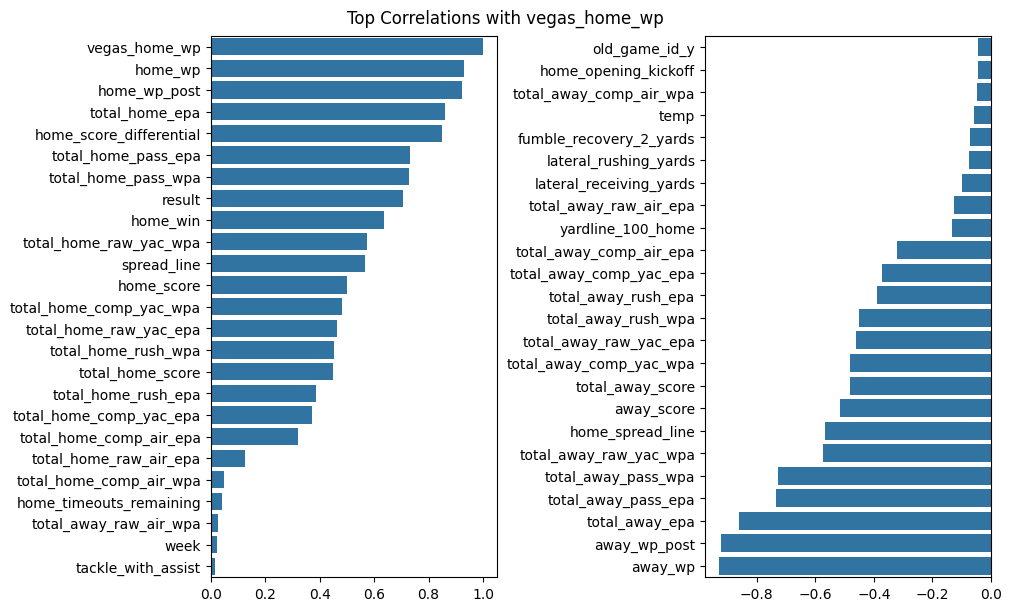

In [8]:
# View correlations.
target = 'vegas_home_wp'
corr = df.corr(numeric_only = True)[target].sort_values(ascending = False)

fig, ax = plt.subplots(1, 2, figsize = (10,6), constrained_layout = True)
top_corr = corr[:25]
bottom_corr = corr[-30:-6]


sns.barplot(x = top_corr.values, y = top_corr.index,  ax = ax[0])
sns.barplot(x = bottom_corr.values, y = bottom_corr.index, ax = ax[1])

fig.align_xlabels()

ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.suptitle('Top Correlations with vegas_home_wp')

plt.show()

Although `epa` (expected points added) and `wpa` (win probability added) show strong correlations with the target, we exclude them because they are derived, post-play statistics that incorporate information not available before the snap. 

Our objective is to model win probability *before the play occurs*.

In [9]:
# Exclude columns containing 'epa' or 'wpa'. 
exclude_substrings = ['epa', 'wpa']

cols_to_keep = []

for col in df.columns: 
    if 'epa' in col:
        continue
    if 'wpa' in col:
        continue
    else:
        cols_to_keep.append(col)
len(cols_to_keep)

359

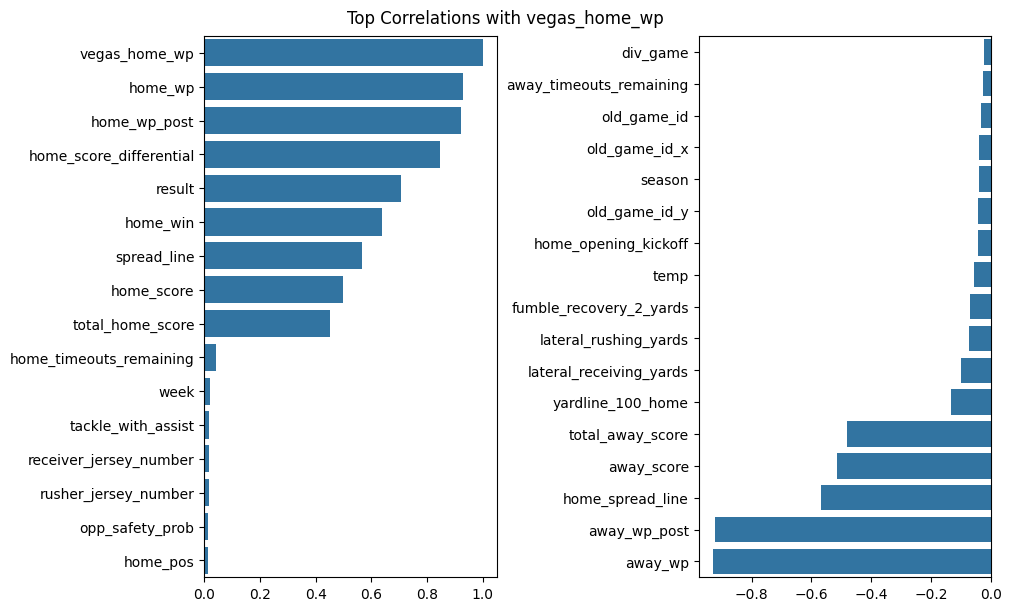

In [10]:
# Plot correlations.
filtered_corr = df[cols_to_keep].corr(numeric_only = True)[target].sort_values(ascending = False)

top_corr = filtered_corr[:16]
bottom_corr = filtered_corr[-23:-6]

fig, ax = plt.subplots(1, 2, figsize = (10,6), constrained_layout = True)

sns.barplot(x = top_corr.values, y = top_corr.index,  ax = ax[0])
sns.barplot(x = bottom_corr.values, y = bottom_corr.index, ax = ax[1])

fig.align_xlabels()

ax[0].set_ylabel('')
ax[1].set_ylabel('')

plt.suptitle('Top Correlations with vegas_home_wp')
plt.show()

Based on these correlations, we subset our desired pre-play game state features for modeling.

In [11]:
# Create preliminary list of features.
features = ['game_id', 
            'home_pos',
            'down',
            'ydstogo',
            'yardline_100_home',
            'time_weight',
            'home_score_differential',
            'desc',
            'play_type_nfl',
            'home_spread_line',
            'game_seconds_remaining',
            'home_timeouts_remaining',
            'away_timeouts_remaining',
            'home_win',
            'vegas_home_wp'
           ]

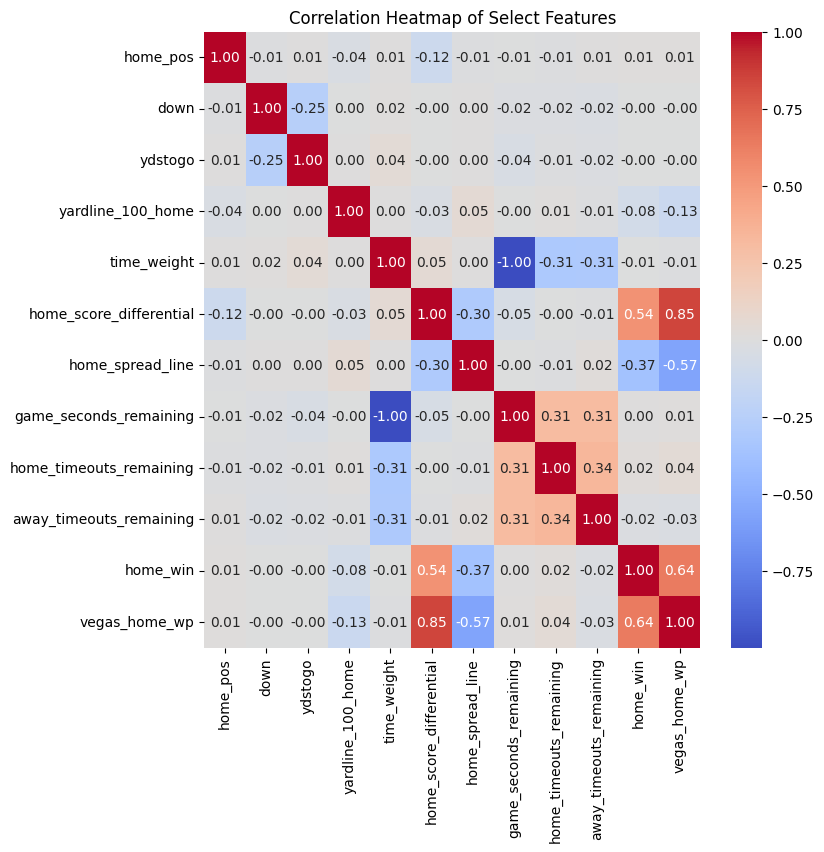

In [12]:
# View heatmap of correlations.
plt.figure(figsize=(8, 8))
sns.heatmap(df[features].corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Select Features")
plt.show()

Our target is most correlated with score differential and the opening point spread, as well as home_win. 

We are including home_win here as a reference point, and it will not be included in modeling.

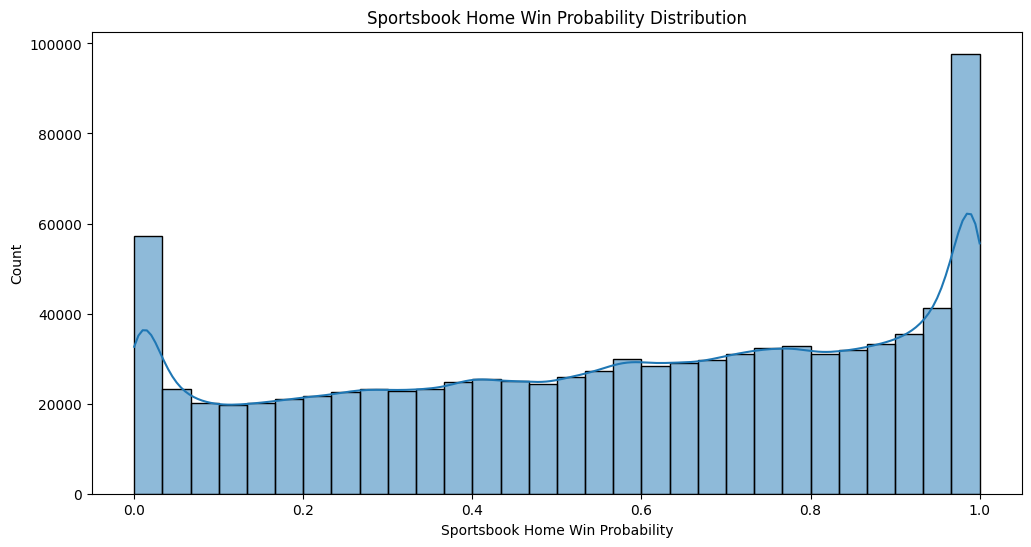

In [13]:
# View histogram of target.
plt.figure(figsize=(12, 6))
sns.histplot(df['vegas_home_wp'], bins=30, kde=True)
plt.title("Sportsbook Home Win Probability Distribution")
plt.xlabel("Sportsbook Home Win Probability")
plt.show()

Our target is bimodal, with peaks hear 0 and 1. 

There is enough data spread out between the peaks that our model can learn from both close games and blowouts.

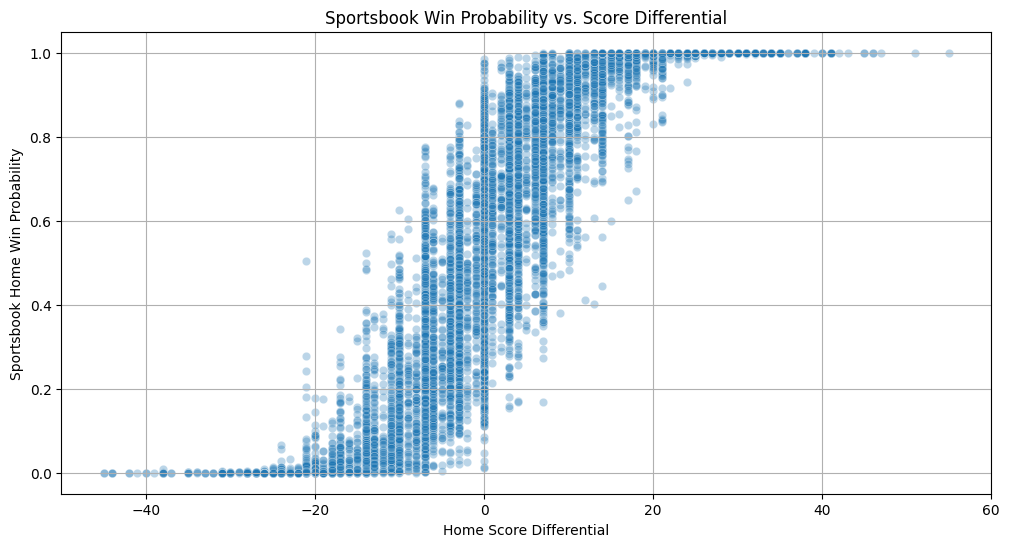

In [14]:
# View scatterplot of probability vs. score differential.
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df.sample(10000, random_state = 42), # Random sample.
                x='home_score_differential', 
                y='vegas_home_wp', 
                alpha=0.3)
plt.title("Sportsbook Win Probability vs. Score Differential")
plt.xlabel("Home Score Differential")
plt.ylabel("Sportsbook Home Win Probability")
plt.grid(True)
plt.show()

Little movement at probabilities near 0 and 1. Our model will likely perform better in between these extremes.

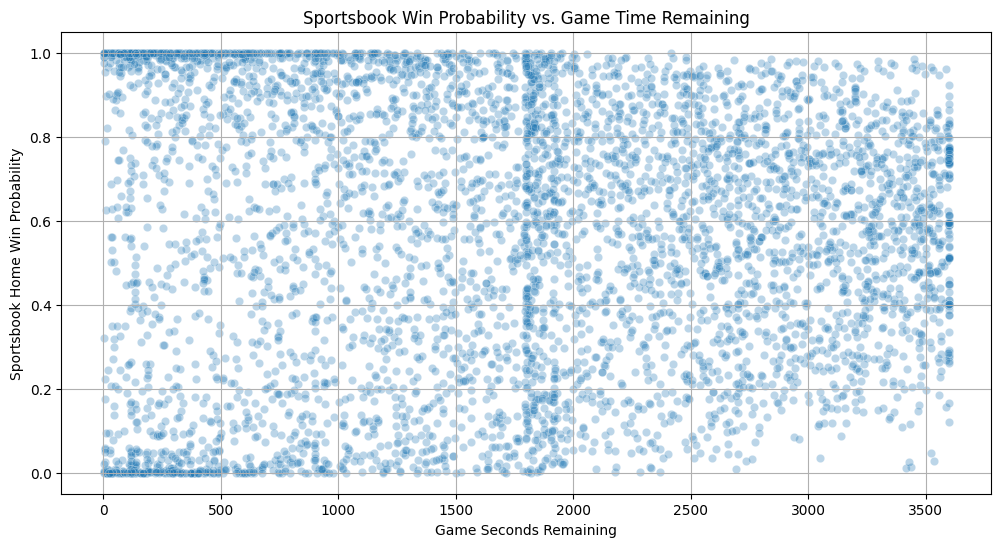

In [15]:
# View scatterplot of win probability vs. time remaining.
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df.sample(5000, random_state = 42), 
    x='game_seconds_remaining',
    y='vegas_home_wp',
    alpha=0.3
)
plt.title("Sportsbook Win Probability vs. Game Time Remaining")
plt.xlabel("Game Seconds Remaining")
plt.ylabel("Sportsbook Home Win Probability")
plt.grid(True)
plt.show()

Unsurprisingly, probabilities are centered toward the middle at the beginning of games and cluster around 0 and 1 toward the end.

In [16]:
# View null counts.
df[features].isna().sum()
# df = df[pre_features].copy()

game_id                        0
home_pos                       0
down                       93053
ydstogo                        0
yardline_100_home           5934
time_weight                  179
home_score_differential     5934
desc                           0
play_type_nfl                  0
home_spread_line               0
game_seconds_remaining       179
home_timeouts_remaining        0
away_timeouts_remaining        0
home_win                       0
vegas_home_wp                  0
dtype: int64

In [17]:
# View description of down nulls.
df[df['down'].isna()]['desc']

183951                                                                                                                                                                                               GAME
183952                                                                                           7-B.Gramatica kicks 59 yards from ARI 30 to DET 11. 18-E.Drummond to DET 30 for 19 yards (34-D.Jackson).
183976                                                                                            7-B.Gramatica kicks 60 yards from ARI 30 to DET 10. 18-E.Drummond to DET 42 for 32 yards (82-K.Kasper).
183986                                                                                                4-J.Hanson kicks 70 yards from DET 30 to ARI 0. 82-K.Kasper to ARI 21 for 21 yards (28-Bra.Walker).
184001     4-J.Hanson kicks 67 yards from DET 30 to ARI 3. 82-K.Kasper to ARI 34 for 31 yards (28-Bra.Walker). PENALTY on DET-82-C.Fitzsimmons, Offensive Offside, 5 yards, enforced at DET 30 -

In [18]:
# View field position nulls.
df[df['yardline_100_home'].isna()]['desc']

183951     GAME
184133     GAME
184300     GAME
184488     GAME
184673     GAME
           ... 
1229932    GAME
1230113    GAME
1230303    GAME
1230480    GAME
1230679    GAME
Name: desc, Length: 5934, dtype: object

These null values appear to be a combination of timeouts, kickoffs, period changes, penalties, and conversions. We drop them.

In [19]:
# Drop nulls from desired columns.
df.dropna(subset = ['yardline_100'], inplace = True)
df.dropna(subset = ['down'], inplace = True)

In [20]:
# View remaining nulls
df[features].isna().sum()

game_id                    0
home_pos                   0
down                       0
ydstogo                    0
yardline_100_home          0
time_weight                0
home_score_differential    0
desc                       0
play_type_nfl              0
home_spread_line           0
game_seconds_remaining     0
home_timeouts_remaining    0
away_timeouts_remaining    0
home_win                   0
vegas_home_wp              0
dtype: int64

No remaining nulls.

In [21]:
df_filtered = df[features].copy()
df_filtered.to_csv('df_filtered.csv')

## EDA Summary

Key findings:
 - Dropped pre-2003 due to scoring inconsistencies.
 - Reframed spreads relative to home team for clarity.
 - Excluded post-play features (EPA, WPA) to prevent data leakage.
 - Dropped rows with null values.